In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import math
# %gui tk  # 今回 tk 不要

# ダイコン画像の自動２階調化プログラム
まずはデモから

In [2]:
def  demo(filename, inverse=False):
    rad= cv2.imread(filename) 
    if len(rad.shape)<3:
        rad = cv2.cvtColor(rad,cv2.COLOR_GRAY2BGR)
    grabimg, _mm,_index, _m1, _m2, grabmask = getRadish(rad, needDetail=True, inverse=inverse)
    plt.figure(figsize=(10,12))
    plt.subplot(131)
    plt.imshow(rad[:,:,::-1])
    plt.subplot(132)
    plt.imshow(grabmask)
    plt.subplot(133)
    plt.imshow(grabimg[:,:,::-1]) 
    plt.show()

In [3]:
MINIMAXSIZE = 256

def getRadish(img,  minimaxsize = MINIMAXSIZE, needDetail=False, inverse=False):
        
    height, width =  img.shape[0],img.shape[1]
        
    if inverse: #  背景が白の場合 grabcut で対象を切り出すことで結果的に背景を黒に変える
        img =  py.grabcut(img, offset=150/np.min(img.shape[:2]))

    # 大きめのガウシアンフィルタでぼかした後に大津の方法で２階調化
    # ２値化のためにグレー画像をつくる
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(35,35),0)  
    _,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    (x,y,w,h) = py.getRect(otsu,needImage=False) # 画像中の白系領域で最も大きな領域を囲む矩形を求める
    
    dh,dw = 0.1*h,0.1*w
    rrect = ((x-dw)/width, (y-dh)/height, (w+2*dw)/width, (h+2*dh)/height) # 若干大きめにする

    mm = py.mulresimg(img,pad=1,offset=-1,rect=rrect) # 多重解像度画像の生成
    
    for index,img in enumerate(mm):
          if np.min(img.shape[:2]) <= minimaxsize:
            break
    
    # これから処理対象とする画像
    src = mm[index] 
    src = py.margincut(src, pad=1) # ピラミッド化で余分な空白がついているのでカット 10%の余白は残す

    # ２値化のためにグレー画像をつくる
    gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

    # 大きめのガウシアンフィルタでぼかした後に大津の方法で２階調化
    blur = cv2.GaussianBlur(gray,(35,35),0)  
    _,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                           
    # 指標等がいっしょに写り込んでいる可能性があるので、最大の白領域だけ抜き出す
    # 葉がいっぱいついている場合には対応できない
    otsu = py.getMainArea(otsu, inverse=False, needRect=False)
        
    iter = int(0.02*np.min(src.shape[:2])) 
    
    # 膨張処理で確実に背景である領域をマスク
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)) # 円形カーネル
    #kernel =cv2.getStructuringElement(cv2.MORPH_CROSS,(iter,iter)) # 十字カーネル
    mask1 = 255-cv2.dilate(otsu,kernel,iterations = iter)
    
    # 収縮処理で確実に内部である領域をマスク
    mask2 = cv2.erode(otsu,kernel,iterations = iter)

    # grabcut　用のマスクを用意 
    grabmask = np.ones(src.shape[:2],np.uint8)*2
    # 
    grabmask [mask1==255]=0     # 黒　　背景　　
    grabmask [mask2==255]=1    # 白　前景

    # plt.imshow(grabmask*127)
    # plt.show()
    
    # grabcut の作業用エリアの確保
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    # MASK による grabcut 実行
    grabmask, bgdModel, fgdModel = cv2.grabCut(src,grabmask,None,bgdModel,fgdModel,20,cv2.GC_INIT_WITH_MASK)
    grabmask = np.where((grabmask==2)|(grabmask==0),0,1).astype('uint8')
    grabimg = src*grabmask[:,:,np.newaxis]

    if needDetail:
        return grabimg, mm, index, mask1,mask2, grabmask
    else:
        return grabimg

In [4]:
import impyramid as py

## 以下のメソッド impyramid.py にまとめた
> def getbase2img(img): 　　
>> 最寄りの２のべき乗サイズになるようにサイズ変更する。不足分は黒画素で埋める。

> def grabcut(img, offset=5, rect=(0,0,1,1)): 　　 
>> Grabcut をマージン5%だけを背景指定して得られる画像を返す  


> def margincut(img,pad=5, needRect = False):  
>> return image,(x1,y1,x2,y2)  grabcut されていることが前提で、背景は完全黒である画像の完全黒部分を余白としてカットする  


> def mulresimg(img,minsize=128,pad=-1,offset=5, rect=None)): 
>> 多重解像度画像の生成  オプションで最初に grabcut, margicut.  オプション引数はそれらのメソッドに引き渡される。

> def showMimg(mimg, needShow=True): 
>> 多重解像度画像を一枚にまとめて表示し、その画像を返す

> def showBigImage(img):
>> 大きな画像の表示　スクロール、拡大縮小可

> def getRect(img,  inverse=False, needImage=False):
>> 与えら得た画像を２値化したとき大きい方から areanum 番目の領域のバウンダリ矩形を返すメソッド  
オプションで結果画像も返す

> def getMainArea(bwimg, inverse=False, needRect=False):
>> ２値画像の連結成分のうち最大のものを返すメソッド　  
オプションで結果画像も返す



## 実行結果１

label 0   areas 625957  circle level 0.5241253093144176    likeness 328079.9062425249
label 1   areas 186449  circle level 0.4832573264733811    likeness 90102.84526363543
２のべき乗サイズに変換 807 486 -> 1024 512


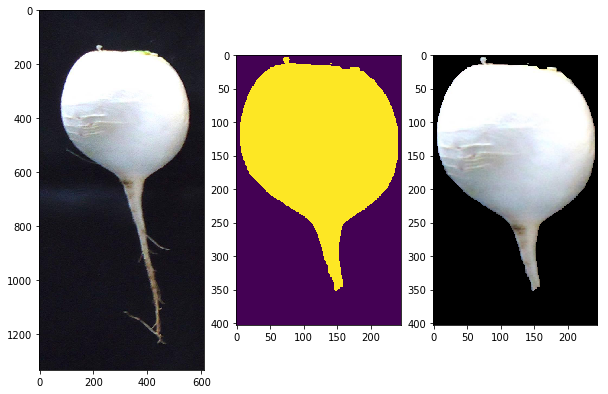

In [5]:
filename = "pics/daikonkabu.jpg" 
demo(filename)

尻尾をどこまで残すべきかが問題であるが、このプログラムではこの結果が示すように細長く伸びている部分は自動的にカットされる

# 実験結果２

label 0   areas 11101170  circle level 0.7129636203197538    likeness 7914730.352985041
label 1   areas 839801  circle level 0.3071689216216728    likeness 257960.76754680244
label 2   areas 59029  circle level 0.7907333141265527    likeness 46676.196799576275
２のべき乗サイズに変換 2390 922 -> 4096 1024


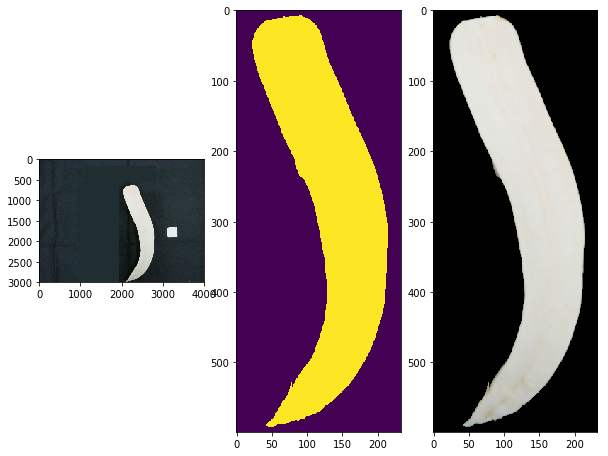

In [6]:
filename = "pics/horyou2c6k.jpg" 
demo(filename)

一番大きな面積のエリアを切り出すので、小さければ指標その他のものが写っていても構わない。

# 実験結果３

label 0   areas 281935  circle level 0.2679208725911898    likeness 75536.2712139971
label 1   areas 38276  circle level 0.29279051238211673    likeness 11206.8496519379
label 2   areas 1174  circle level 0.716040354861529    likeness 840.631376607435
label 3   areas 38531  circle level 0.4872697547268163    likeness 18774.990919378957
label 4   areas 84  circle level 0.6914783570975486    likeness 58.08418199619408
２のべき乗サイズに変換 395 315 -> 512 512


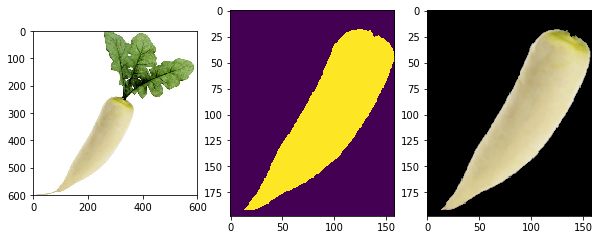

In [7]:
filename = "pics/daikon2.jpg" 
demo(filename, inverse=True)

このダイコン画像は実は大変難しい。理由は

- 背景が白である
- 葉がついていおり、その面積が主要部分より大きい

背景が白の場合は オプションとして  inverse=True を指定すれば対応できるようにしてある。ただしこの例しか試していないので、一般的にうまくいくかどうかはわからない。

葉の面積が大きかった場合に対応するために、選択基準を面積ではなく、面積×円形度とした。

label 0   areas 125840  circle level 0.6616214769956598    likeness 83258.44666513383
label 1   areas 19  circle level 1.2358490732420422    likeness 23.481132391598802
label 2   areas 2  circle level 6.283185307179586    likeness 12.566370614359172
label 3   areas 22769  circle level 0.44155958645583776    likeness 10053.87022401297
２のべき乗サイズに変換 334 226 -> 512 256


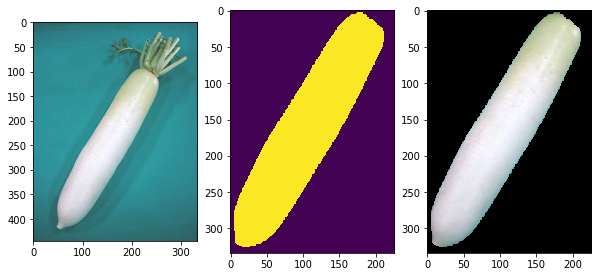

In [8]:
filename =  "pics/daikon1.jpg" 
demo(filename)

label 0   areas 587555  circle level 0.49197060838720974    likeness 289059.790810947
label 1   areas 186795  circle level 0.4795322522039433    likeness 89574.22705043558
label 2   areas 38056  circle level 0.8244824896066202    likeness 31376.505624469537
２のべき乗サイズに変換 895 519 -> 1024 1024


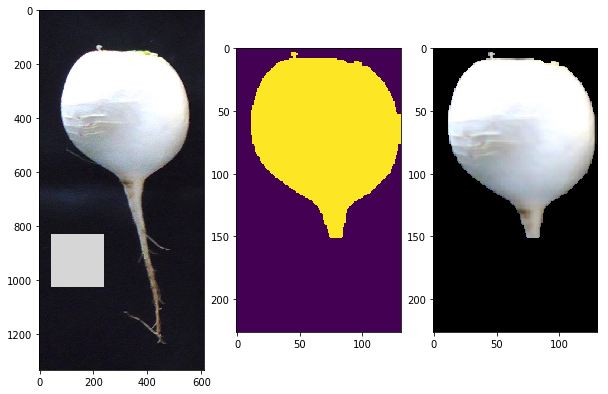

In [9]:
filename = "pics/daikonkabu.png"
demo(filename)

label 0   areas 59705  circle level 0.5370140070103401    likeness 32062.421288552356
label 1   areas 28797  circle level 0.4418426614511521    likeness 12723.743121808826
２のべき乗サイズに変換 198 309 -> 256 512


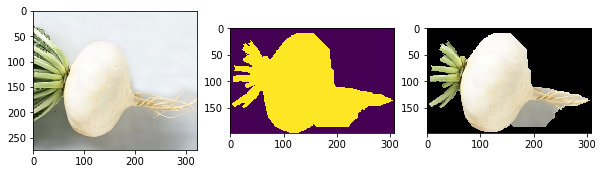

In [10]:
filename = "pics/kabu2.jpg"
demo(filename,inverse=True)
# py.grabcut_main()

これは背景が白でかつ陰があるのでとても難しい。 →　py.grabcut_main() でインタラクティブに処理

[結果]("https://imgur.com/FG7g5F3")

label 0   areas 366932  circle level 0.21106485952247409    likeness 77446.45103430047
label 1   areas 503  circle level 0.7367136992718175    likeness 370.5669907337242
label 2   areas 477  circle level 0.38293535504925125    likeness 182.66016435849284
label 3   areas 671  circle level 0.6451238819224334    likeness 432.8781247699528
label 4   areas 21  circle level 1.603549383693564    likeness 33.67453705756484
label 5   areas 189  circle level 0.9266167238104239    likeness 175.13056080017012
label 6   areas 42  circle level 1.0439086755967186    likeness 43.844164375062185
label 7   areas 728  circle level 0.6534037215781098    likeness 475.6779093088639
label 8   areas 321  circle level 0.9345535593368025    likeness 299.9916925471136
label 9   areas 146  circle level 1.009682183290977    likeness 147.41359876048264
label 10   areas 173  circle level 0.8766271274761668    likeness 151.65649305337686
label 11   areas 147  circle level 0.989223173876738    likeness 145.41580655988

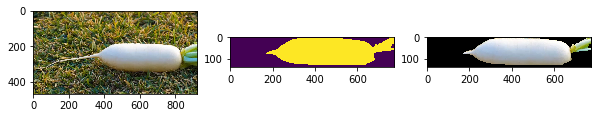

In [11]:
filename = "pics/d1004.jpg" 
demo(filename)

実験ここまで　以下はプログラムの解説

# ダイコン画像の２値化

ダイコンはおおむね白一色なので背景と照明を工夫すれば比較的容易に２階調化できそうなものであるが、それでもヒゲが出ていた入、くぼみが黒ずんでいたりするし、照明の具合で影や陰ができるので、影は分離し、陰は残すといったことはなかなか難しい。


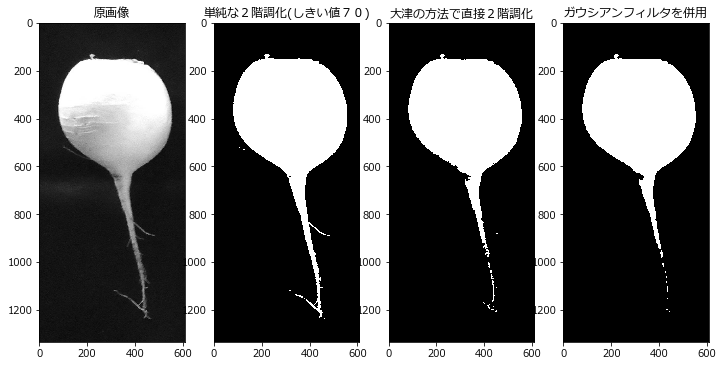

In [12]:
filename = "pics/daikonkabu.jpg" 
org= cv2.imread(filename,0) # 画像の読み込み
_,bin = cv2.threshold(org,70,255,cv2.THRESH_BINARY)
_,otsu0 = cv2.threshold(org,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
blur = cv2.GaussianBlur(org,(15,15),0)  
_,otsu1 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
fig = plt.figure(figsize=(12,6))
plt.rcParams['font.family'] = 'Meiryo'
plt.subplot(141)
plt.title('原画像')
plt.imshow(org,cmap='gray')
plt.subplot(142)
plt.title('単純な２階調化(しきい値７０)')
plt.imshow(bin,cmap='gray')
plt.subplot(143)
plt.title('大津の方法で直接２階調化')
plt.imshow(otsu0,cmap='gray')
plt.subplot(144)
plt.title('ガウシアンフィルタを併用')
plt.imshow(otsu1,cmap='gray')
plt.show()

単純な２階調化ではしきい値決定の問題があるが、大津の方法（判別分析法）を用いればある程度はベストに近いしきい値が自動的に決まってくれる。2階調化に先立ってガウシアンフィルタをかけ、その後大津の方法を適用すると比較的なめらかなシルエットが得られる。

# GrabCut と大津の方法による自動２階調化

単純に一つのしきい値だけによる２階調化では、上のダイコンのくぼみのように相対的に暗い部分はどうしても黒になってしまうが、面の連続性

GrabCut 



# getbase2img 
縦横の幅を2のべき乗になるように黒画素で埋める

２のべき乗サイズに変換 1334 609 -> 2048 1024


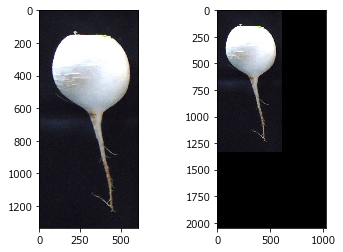

In [13]:
daikonname = "pics/daikonkabu.jpg" 
org = cv2.imread(daikonname,1)
b2img = py.getbase2img(org)

plt.subplot(121)
plt.imshow(org[:,:,::-1])
plt.subplot(122)
plt.imshow(b2img[:,:,::-1])
plt.show()

# 多重解像度画像の生成と表示

## **mulresimg** 
第１引数で与えた画像を getbase2img で２のべきサイズに変換した後多重解像度画像（画像のリスト）を返す

mulresimg のオプション
- **pad** 正の数を与えた場合はpad で指定するパーセント分余白を残して無駄な余白を削る。
- **offset**  pad が正の場合、必ず先に　Grabcut を通す。Grabcut で指定する枠を　この値でコントロールする。  
正の数を与えば場合は縦横の長さに対するパーセンテージを意味し、端からその割合離した矩形がGrabcat で使う rect となる。  
負の数を与えた場合は、rect で指定する枠を使う。大きさは実サイズに対する比率。例えば、(0.1,0.2,0.8,0.6) 

## **showMimg** 
多重解像度画像（画像のリスト）を渡すと１枚の画像に合成して表示するとともにその画像を返す。

２のべき乗サイズに変換 1334 609 -> 2048 1024


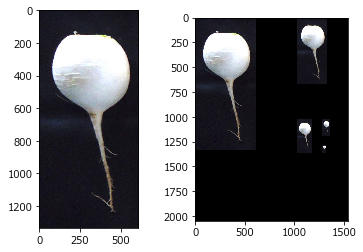

In [14]:
filename = "pics/daikonkabu.jpg" 
org= cv2.imread(filename,1) # 画像の読み込み
mm = py.mulresimg(org)
mm_img=py.showMimg(mm,needShow=False);
plt.subplot(121)
plt.imshow(org[:,:,::-1])
plt.subplot(122)
plt.imshow(mm_img[:,:,::-1])
plt.show()

表示すると無駄が多いが気にしない。画像を取り出してから余白はカットして使えばいいのだが、オプションでカットを試みることもできる。例えば次の例の場合、非常に無駄な余白が多い。

２のべき乗サイズに変換 3000 4000 -> 4096 4096


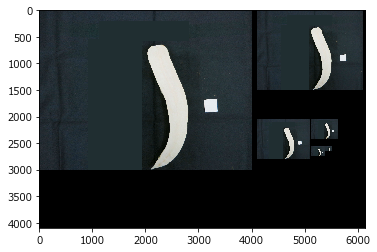

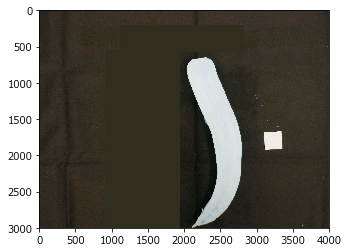

In [15]:
# 1%枠でGrabCut、MarginCutして多重解像度化
test= cv2.imread("pics/horyou2c6k.jpg",1) # 画像の読み込み
py.showMimg(py.mulresimg(test) )
plt.imshow(test)
plt.show()

対象が下端ギリギリなので、当比率の枠は使えないので rect オプション指定をする必要がある。

２のべき乗サイズに変換 2812 2041 -> 4096 2048


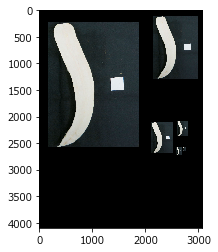

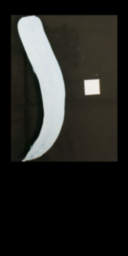

In [16]:
mm = py.mulresimg(test,pad=10,offset=-1,rect=(0.3,0.15,0.7,0.85))
py.showMimg(mm);
Image.fromarray(mm[4])

上の例では指標が入るように指定したが、以下では邪魔なのでダイコンだけが入るように指定してみる。

２のべき乗サイズに変換 2484 981 -> 4096 1024


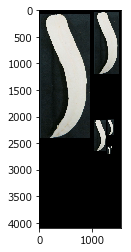

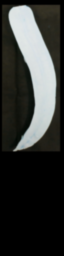

In [17]:
mm = py.mulresimg(test,pad=3,offset=-1,rect=(0.4,0.15,0.32,0.85))
py.showMimg(mm);
Image.fromarray(mm[4])

このような作業を手作業で行うのは大変面倒なので自動化したい。

label 0   areas 11101201  circle level 0.7129656112695572    likeness 7914774.556791219
label 1   areas 840067  circle level 0.30229063066746703    likeness 253944.38323292704
label 2   areas 58732  circle level 0.7782592024747335    likeness 45708.71947974605
最大領域を囲む矩形 (2038, 649, 763, 2345)


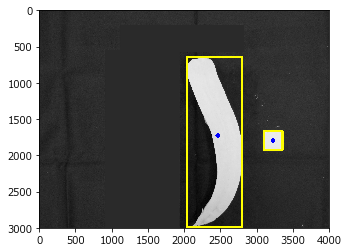

In [18]:
test= cv2.imread("pics/horyou2c6k.jpg",1) # 画像の読み込み
rect, labelimg = py.getRect(test,needImage=True)
print("最大領域を囲む矩形",rect)
plt.imshow(labelimg)
plt.show()

(0.49996249999999998, 0.17724999999999999, 0.20982499999999998, 0.85983333333333334)
２のべき乗サイズに変換 2484 857 -> 4096 1024
実サイズ


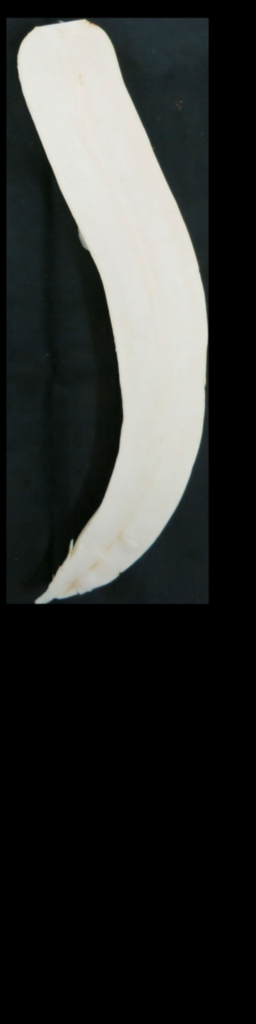

In [19]:
height=test.shape[0]
width=test.shape[1]
x0,y0,w,h = rect[0],rect[1],rect[2],rect[3]
dh = h*0.05
dw = w*0.05
rrect = ((x0-dw)/width, (y0-dh)/height, (w+2*dw)/width, (h+2*dh)/height) # 若干大きめにする
#rect = (rect[0]/w,rect[1]/h,rect[2]/w,rect[3]/h)
print(rrect)
mm = py.mulresimg(test,pad=3,offset=-1,rect=rrect)

# サイズが無駄に大きいと処理時間がかかるのでほどよいサイズで処理したい
# 短辺が256以下になる解像度を選ぶ
MINIMAXSIZE = 256
for index,img in enumerate(mm):
      if np.min(img.shape[:2]) <= MINIMAXSIZE:
        break
# これから処理対象とする画像
src = mm[index] 
print("実サイズ")
Image.fromarray(src[:,:,::-1])

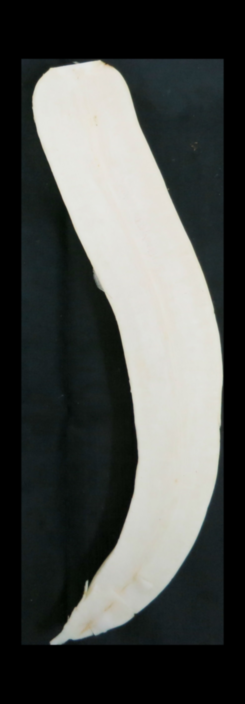

In [20]:
src = py.margincut(src,pad=10) # ピラミッド化で余分な空白がついているのでカット
Image.fromarray(src[:,:,::-1])

In [21]:
height = src.shape[0]
width = src.shape[1]
print("処理対象は縮小レベル{} サイズ＝縦{},横{}".format(index,height,width))

処理対象は縮小レベル2 サイズ＝縦704,横245


# マスク生成
確実にダイコン内部である領域と、確実に背景である領域を分けるためのマスクをつくる。  
結果的に長いひげ根はカットされる。

ヒゲのある画像例で説明する。

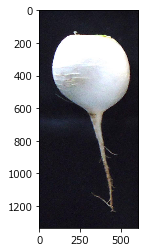

In [22]:
filename = "pics/daikonkabu.jpg" 
src = cv2.imread(daikonname,1)
plt.imshow(src[:,:,::-1])
plt.show()

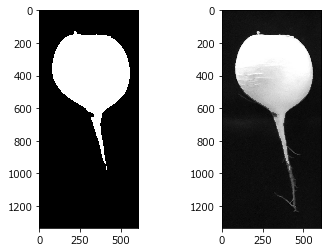

In [23]:
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

# 大きめのガウシアンフィルタでぼかした後に大津の方法で２階調化
blur = cv2.GaussianBlur(gray,(25,25),0)  
_,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.subplot(121)
plt.imshow(otsu,cmap='gray')
plt.subplot(122)
plt.imshow(Image.fromarray(cv2.addWeighted(otsu, 0.3, gray, 0.7,0.0)),cmap='gray') 
plt.show()

# 複数の図形が含まれる場合の対処法
指標等が写り込んだ写真の場合は最大の面積の領域だけ取り出す必要があろう。

getMainArea() で最も面積の大きい領域を抜き出せる。

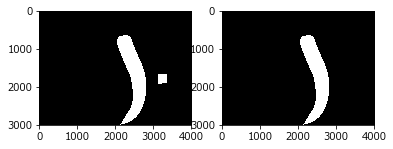

In [24]:
test= cv2.imread("pics/horyou2c6k.jpg",0) # 画像の読み込み
blurtest = cv2.GaussianBlur(test,(25,25),0)  
_,otsutest = cv2.threshold(blurtest,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.subplot(121)
plt.imshow(otsutest,cmap='gray')
plt.subplot(122)
plt.imshow(py.getMainArea(otsutest),cmap='gray')
plt.show()

確実に背景である領域


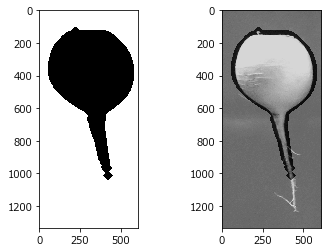

In [25]:
# 膨張処理で確実に背景である領域をマスク
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) # 円形カーネル
kernel =cv2.getStructuringElement(cv2.MORPH_CROSS,(7,7)) # 十字カーネル
mask1 = 255-cv2.dilate(otsu,kernel,iterations = 9)
print("確実に背景である領域")
plt.subplot(121)
plt.imshow(mask1,cmap='gray')
plt.subplot(122)
plt.imshow(Image.fromarray(cv2.addWeighted(mask1, 0.3, gray, 0.7,0.0)),cmap='gray') 
plt.show()

白の領域は確実に対象物のないエリアである。

確実に対象内である領域


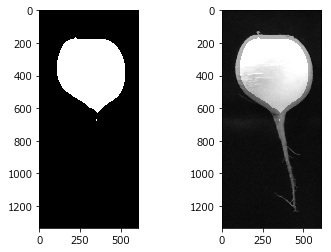

In [26]:
# 収縮処理で確実に内部である領域をマスク
mask2 = cv2.erode(otsu,kernel,iterations = 9)
print("確実に対象内である領域")
plt.subplot(121)
plt.imshow(mask2,cmap='gray')
plt.subplot(122)
plt.imshow(Image.fromarray(cv2.addWeighted(mask2, 0.3, gray, 0.7,0.0)),cmap='gray') 
plt.show()

こちらのマスクは確実に対象物内であるエリアを示している。

# GrabCut による切り出し


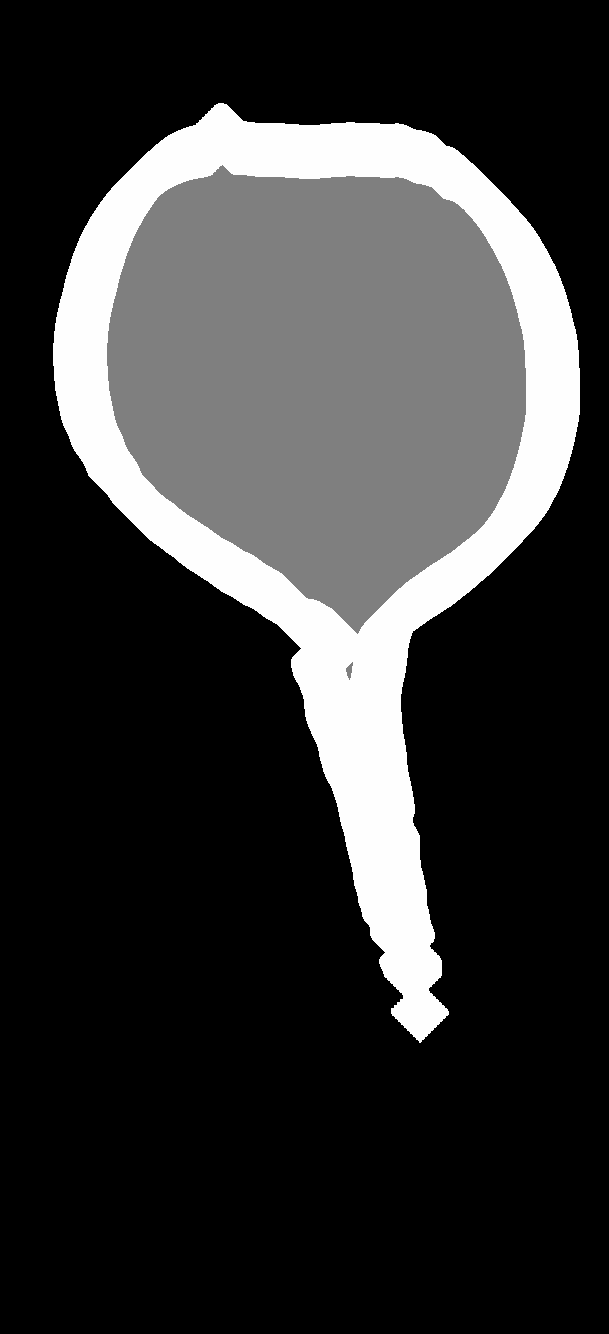

In [27]:
# grabcut　用のマスクを用意 
grabmask = np.ones(src.shape[:2],np.uint8)*2
# オーツの方法 に基づくユーザ指定
grabmask [mask1==255]=0     # 黒　　背景　　
grabmask [mask2==255]=1    # 白　前景
Image.fromarray(grabmask*127)  # この図では　黒：背景確定、白：？領域、グレー：前景確定

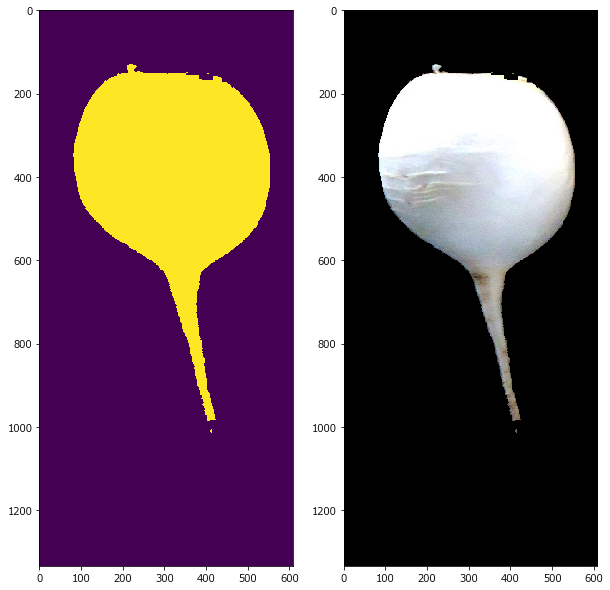

In [28]:
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

grabmask, bgdModel, fgdModel = cv2.grabCut(src,grabmask,None,bgdModel,fgdModel,20,cv2.GC_INIT_WITH_MASK)
grabmask = np.where((grabmask==2)|(grabmask==0),0,1).astype('uint8')
grabimg = src*grabmask[:,:,np.newaxis]

plt.figure(figsize=(10,12))
plt.subplot(121)
plt.imshow(grabmask)
plt.subplot(122)
plt.imshow(grabimg[:,:,::-1]) 
plt.show()